General idea : Compare the performance of denoising using only wavelet transform and also extracting noise using wavelet, training the model on that, and predicting type of noise.

Only wavelet transform might leave the image be cleaner than noisy image, but we have to determine if its enough

In [1]:
# Note : The current code only takes into account each individual color channel and not a combination of all.

In [2]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as compare_ssim
import tensorflow as tf
import numpy as np
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [3]:
# As size of images are different, we will resize all images into common size.
image_width = 400
image_height = 300


def load_image(image_path):
    image = cv2.imread(image_path)
    if (image is None):
        print('failed to load image with path : ', image_path)
        
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    image = cv2.resize(image, (image_width, image_height))

    print('loaded image with path : ', image_path)
          
    return image

In [4]:
# Load images from data/folder (the clean / ground truth images)
gt_image_name = 'GT_SRGB_010.png'

ground_truth_images = []

for root, dirs, files in os.walk('../data/SIDD_Small_SRGB'):
    for dir in dirs:
        folder_path = os.path.join(root, dir)

        image_path = os.path.join(folder_path, gt_image_name)
        ground_truth_images.append(load_image(image_path))

loaded image with path :  ../data/SIDD_Small_SRGB\0001_001_S6_00100_00060_3200_L\GT_SRGB_010.png
loaded image with path :  ../data/SIDD_Small_SRGB\0002_001_S6_00100_00020_3200_N\GT_SRGB_010.png
loaded image with path :  ../data/SIDD_Small_SRGB\0003_001_S6_00100_00060_3200_H\GT_SRGB_010.png
loaded image with path :  ../data/SIDD_Small_SRGB\0004_001_S6_00100_00060_4400_L\GT_SRGB_010.png
loaded image with path :  ../data/SIDD_Small_SRGB\0005_001_S6_00100_00060_4400_N\GT_SRGB_010.png
loaded image with path :  ../data/SIDD_Small_SRGB\0006_001_S6_00100_00060_4400_H\GT_SRGB_010.png
loaded image with path :  ../data/SIDD_Small_SRGB\0007_001_S6_00100_00100_5500_L\GT_SRGB_010.png
loaded image with path :  ../data/SIDD_Small_SRGB\0008_001_S6_00100_00100_5500_N\GT_SRGB_010.png
loaded image with path :  ../data/SIDD_Small_SRGB\0010_001_S6_00800_00350_3200_N\GT_SRGB_010.png
loaded image with path :  ../data/SIDD_Small_SRGB\0011_001_S6_00800_00500_5500_L\GT_SRGB_010.png
loaded image with path :  ../d

number of images :  160
dimension of each image :  (300, 400, 3)


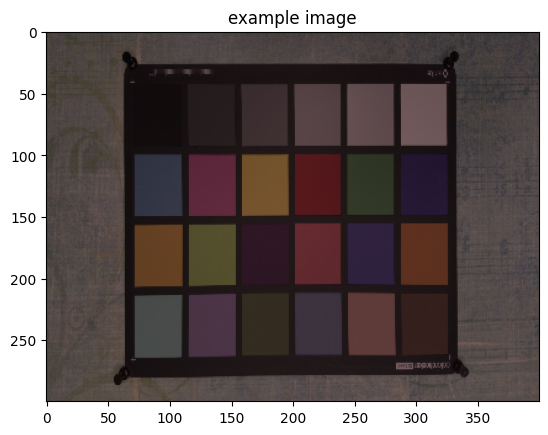

In [5]:
print('number of images : ', len(ground_truth_images))
print('dimension of each image : ', ground_truth_images[0].shape)
plt.title('example image')
plt.imshow(ground_truth_images[0])
plt.show()

In [6]:
# Load images from data/folder (the clean / ground truth images)
noisy_image_name = 'NOISY_SRGB_010.png'

noisy_images = []

for root, dirs, files in os.walk('../data/SIDD_Small_SRGB'):
    for dir in dirs:
        folder_path = os.path.join(root, dir)

        image_path = os.path.join(folder_path, noisy_image_name)
        noisy_images.append(load_image(image_path))

loaded image with path :  ../data/SIDD_Small_SRGB\0001_001_S6_00100_00060_3200_L\NOISY_SRGB_010.png
loaded image with path :  ../data/SIDD_Small_SRGB\0002_001_S6_00100_00020_3200_N\NOISY_SRGB_010.png
loaded image with path :  ../data/SIDD_Small_SRGB\0003_001_S6_00100_00060_3200_H\NOISY_SRGB_010.png
loaded image with path :  ../data/SIDD_Small_SRGB\0004_001_S6_00100_00060_4400_L\NOISY_SRGB_010.png
loaded image with path :  ../data/SIDD_Small_SRGB\0005_001_S6_00100_00060_4400_N\NOISY_SRGB_010.png
loaded image with path :  ../data/SIDD_Small_SRGB\0006_001_S6_00100_00060_4400_H\NOISY_SRGB_010.png
loaded image with path :  ../data/SIDD_Small_SRGB\0007_001_S6_00100_00100_5500_L\NOISY_SRGB_010.png
loaded image with path :  ../data/SIDD_Small_SRGB\0008_001_S6_00100_00100_5500_N\NOISY_SRGB_010.png
loaded image with path :  ../data/SIDD_Small_SRGB\0010_001_S6_00800_00350_3200_N\NOISY_SRGB_010.png
loaded image with path :  ../data/SIDD_Small_SRGB\0011_001_S6_00800_00500_5500_L\NOISY_SRGB_010.png


number of images :  160
dimension of each image :  (300, 400, 3)


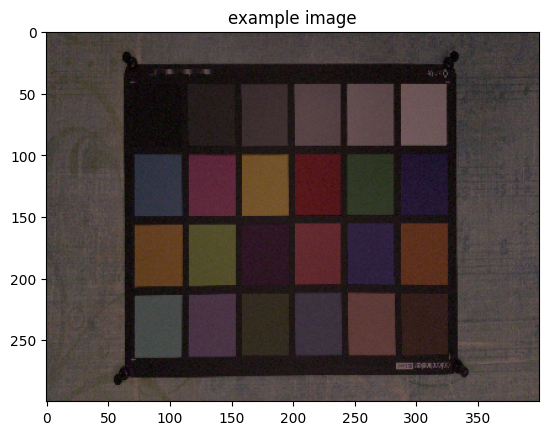

In [7]:
print('number of images : ', len(noisy_images))
print('dimension of each image : ', noisy_images[0].shape)
plt.title('example image')
plt.imshow(noisy_images[0])
plt.show()

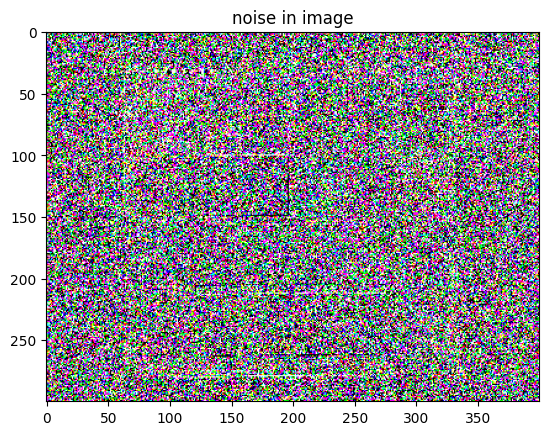

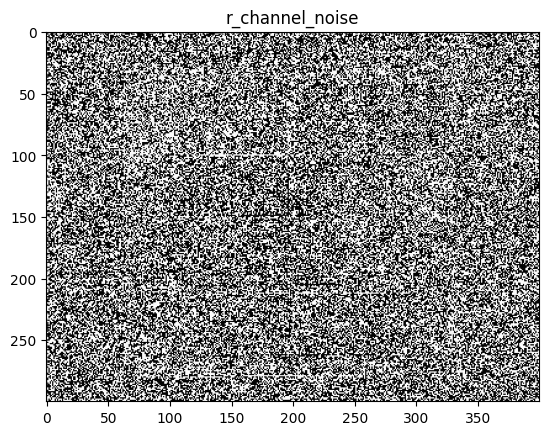

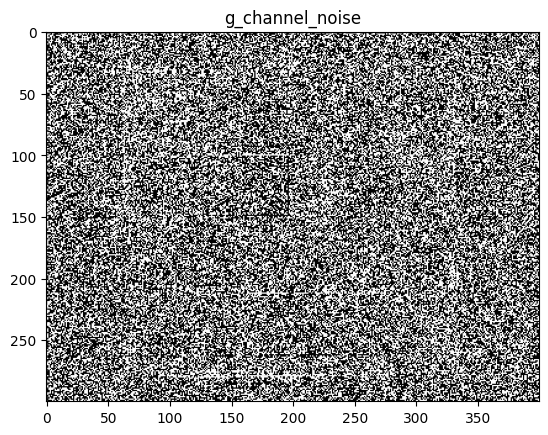

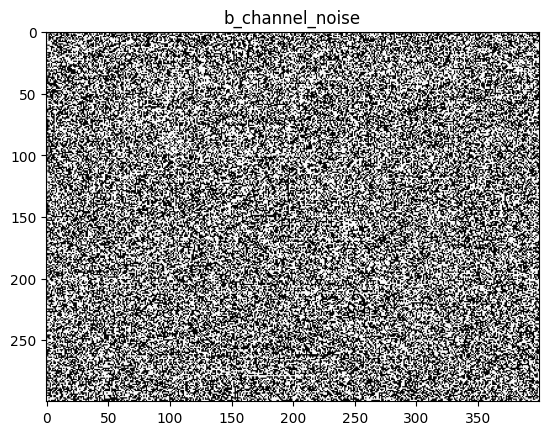

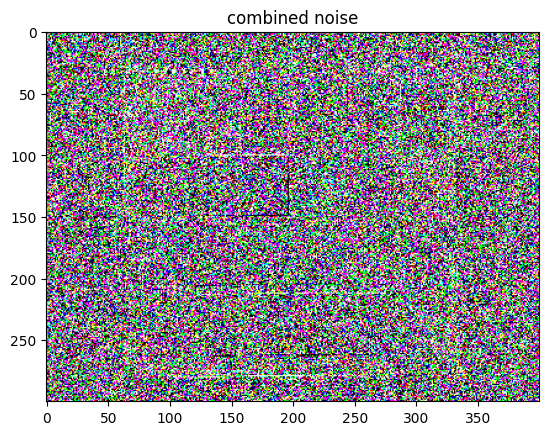

yes, the methods are identical


In [8]:

plt.title('noise in image')
plt.imshow(noisy_images[0] - ground_truth_images[0])
plt.show()

# What datatype is the noise?
np.unique(noisy_images[0] - ground_truth_images[0])

# Is it the same result if each channel is individually subtracted.
r_channel_noise = noisy_images[0][:,:,0] - ground_truth_images[0][:,:,0]
plt.title('r_channel_noise')
plt.imshow(r_channel_noise, cmap='gray')
plt.show()

g_channel_noise = noisy_images[0][:,:,1] - ground_truth_images[0][:,:,1]
plt.title('g_channel_noise')
plt.imshow(g_channel_noise, cmap='gray')
plt.show()

b_channel_noise = noisy_images[0][:,:,2] - ground_truth_images[0][:,:,2]
plt.title('b_channel_noise')
plt.imshow(b_channel_noise, cmap='gray')
plt.show()

combined_noise = np.dstack((r_channel_noise, g_channel_noise, b_channel_noise))

plt.title('combined noise')
plt.imshow(combined_noise)
plt.show()

if (np.all((combined_noise == (noisy_images[0] - ground_truth_images[0])))):
    print('yes, the methods are identical')

Performing wavelet transform

Estimated Gaussian noise standard deviation = 0.020548214615651705


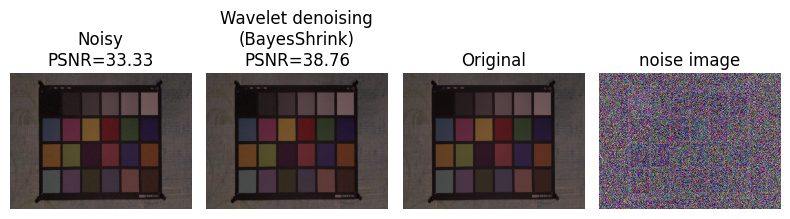

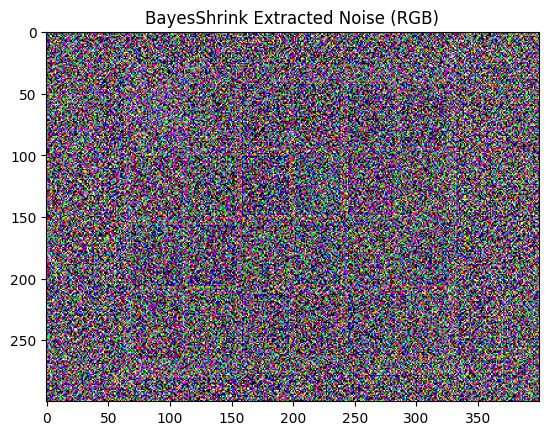

psnr of wavelet denoised image :  38.7564440611099
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18 236 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253
 254 255]
red channel


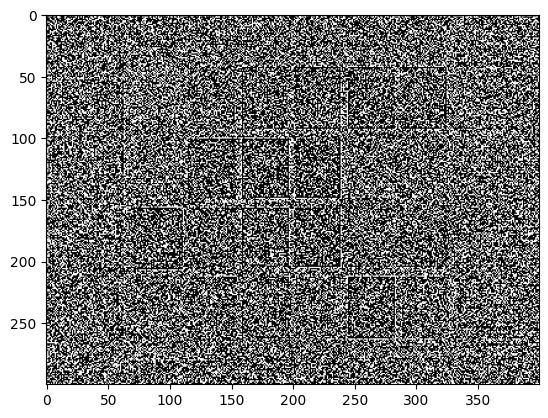

green channel


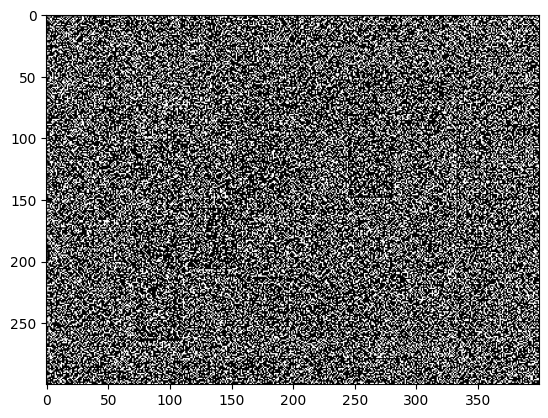

blue channel


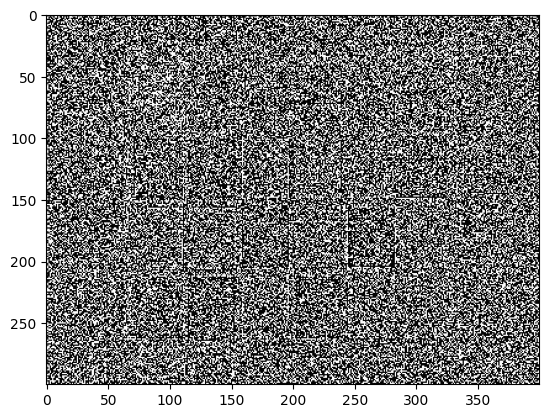

In [9]:
import matplotlib.pyplot as plt
from skimage.color import ycbcr2rgb
from skimage.restoration import denoise_wavelet, estimate_sigma
from skimage import img_as_float
from skimage.metrics import peak_signal_noise_ratio
import numpy as np


def wavelet_denoising(clean_image, noisy_image):
    original_noisy = noisy_image.copy()
    
    clean_image = img_as_float(clean_image.copy())
    noisy_image = img_as_float(noisy_image.copy())
    
    fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(8, 5), sharex=True, sharey=True)
    plt.gray()

    sigma_est = estimate_sigma(noisy_image, channel_axis=-1, average_sigmas=True)
    print(f'Estimated Gaussian noise standard deviation = {sigma_est}')

    im_bayes = denoise_wavelet(noisy_image, channel_axis=-1, convert2ycbcr=True,
                               method='BayesShrink', mode='soft', rescale_sigma=True)

    psnr_noisy = peak_signal_noise_ratio(clean_image, noisy_image)
    psnr_bayes = peak_signal_noise_ratio(clean_image, im_bayes)

    # Convert im_bayes to 0..255 range.
    im_bayes = (np.clip(im_bayes, 0.0, 1.0) * 255).astype(np.uint8)
    
    ax[0].imshow(noisy_image)
    ax[0].axis('off')
    ax[0].set_title(f'Noisy\nPSNR={psnr_noisy:0.4g}')
    ax[1].imshow(im_bayes)
    ax[1].axis('off')
    ax[1].set_title(
        f'Wavelet denoising\n(BayesShrink)\nPSNR={psnr_bayes:0.4g}')
    ax[2].imshow(clean_image)
    ax[2].axis('off')
    ax[2].set_title('Original')
    
    ax[3].imshow(original_noisy - im_bayes)
    ax[3].axis('off')
    ax[3].set_title('noise image')

    fig.tight_layout()
    plt.show()

    extracted_noise = original_noisy - im_bayes

    return extracted_noise, psnr_bayes

bayes_extracted_noise, psnr = wavelet_denoising(ground_truth_images[0], noisy_images[0])

plt.title('BayesShrink Extracted Noise (RGB)')
plt.imshow(bayes_extracted_noise)
plt.show()

print('psnr of wavelet denoised image : ', psnr)

# Analysis of extracted noise data.
print(np.unique(bayes_extracted_noise[:,:,0]))

r, g, b = cv2.split(bayes_extracted_noise)

print('red channel')
plt.imshow(r)
plt.show()

print('green channel')
plt.imshow(g)
plt.show()

print('blue channel')
plt.imshow(b)
plt.show()

In [11]:

# Generation of noise images from clean image.
from enum import Enum

class NoiseTypes(Enum):
    Gaussian = 0
    SaltAndPepper = 1
    Speckle = 2
    Quantization = 3
    Poisson = 4
    Uniform = 5
    White = 6
    Gamma = 7
    Count = 8

In [12]:
import matplotlib.pyplot as plt

def show_image_pair(image1, title1, image2, title2):
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))

    # Show the first image and its histograms
    axes[0, 0].imshow(image1)
    axes[0, 0].set_title(title1)
    axes[0, 0].axis('off')
    
    for i in range(3):
        axes[0, i+1].hist(image1[:,:,i].ravel(), bins=256, color='red', alpha=0.7)
        axes[0, i+1].set_xlim([0, 255])
        axes[0, i+1].set_title(f'Channel {i} Histogram')

    # Show the second image and its histograms
    axes[1, 0].imshow(image2)
    axes[1, 0].set_title(title2)
    axes[1, 0].axis('off')

    for i in range(3):
        axes[1, i+1].hist(image2[:,:,i].ravel(), bins=256, color='blue', alpha=0.7)
        axes[1, i+1].set_xlim([0, 255])
        axes[1, i+1].set_title(f'Channel {i} Histogram')

    plt.tight_layout()

    plt.show()


In [13]:
# Reference : https://medium.com/@ms_somanna/guide-to-adding-noise-to-your-data-using-python-and-numpy-c8be815df524
# Reference : https://theailearner.com/2019/05/07/add-different-noise-to-an-image/
# Reference : https://www.kaggle.com/code/chanduanilkumar/adding-and-removing-image-noise-in-python

# Range of std_deviation : 0->100
import numpy as np
from skimage.util import random_noise


def add_gaussian_noise(channel, mean, std_deviation):
    noise = np.random.normal(mean, std_deviation, channel.shape)
    noisy_channel = channel + noise

    # Clip pixels values in range 0..255
    noisy_channel = np.clip(noisy_channel, 0, 255).astype(np.uint8)
    
    return noisy_channel

def add_salt_and_pepper_noise(channel, probability):
    noisy_channel = np.copy(channel)
    salt_coords = np.where(np.random.rand(*channel.shape) < probability / 2)
    pepper_coords = np.where(np.random.rand(*channel.shape) < probability / 2)
    noisy_channel[salt_coords] = 255
    noisy_channel[pepper_coords] = 0

    # Clip pixels values in range 0..255
    noisy_channel = np.clip(noisy_channel, 0, 255).astype(np.uint8)
    
    return noisy_channel

def add_speckle_noise(channel, intensity):
    noise = np.random.normal(0, intensity, channel.shape)
    noise = noise.reshape(channel.shape[0], channel.shape[1]).astype(np.uint8)
   
    noisy_channel = channel + (channel * noise)

    if (np.all(channel == 0)):
        noisy_channel = noise
        
    # Clip pixels values in range 0..255
    noisy_channel = np.clip(noisy_channel, 0, 255).astype(np.uint8)
    
    return noisy_channel

def add_quantization_noise(channel, intensity):
    
    quantization_error = np.random.uniform(-intensity / 2, intensity / 2, channel.shape)
    noisy_channel = (channel + quantization_error).astype(np.uint8)
    
    return np.clip(noisy_channel, 0, 255)

def add_poisson_noise(channel, intensity):
    noisy_channel = random_noise(channel, mode="poisson") * np.random.uniform(0, intensity)

    # Clip pixels values in range 0..255
    noisy_channel = np.clip(noisy_channel + channel, 0, 255).astype(np.uint8)
    
    return noisy_channel

def add_uniform_noise(channel, intensity):
    noise = np.random.uniform(-intensity, intensity, channel.shape)
    noisy_channel = channel + noise

    # Clip pixels values in range 0..255
    noisy_channel = np.clip(noisy_channel, 0, 255).astype(np.uint8)
    
    return noisy_channel

def add_white_noise(channel, intensity):
    noise = np.random.normal(0, intensity, channel.shape)
    noisy_channel = channel + noise

    # Clip pixels values in range 0..255
    noisy_channel = np.clip(noisy_channel, 0, 255).astype(np.uint8)
    
    return noisy_channel

def add_gamma_noise(channel, shape, scale):
    noise = np.random.gamma(shape, scale, channel.shape)
    noisy_channel = channel + noise

    # Clip pixels values in range 0..255
    noisy_channel = np.clip(noisy_channel, 0, 255).astype(np.uint8)
    
    return noisy_channel


In [14]:
gaussian_noise_images = []
salt_and_pepper_noise_images = []
speckle_noise_images = []
quantization_noise_images = []
poisson_noise_images = []
uniform_noise_images = []
white_noise_images = []
gamma_noise_images = []

# If add_to_array is false, then 
def add_noise_to_image(image, add_to_array = True):
    
    # Gaussian noise
    noisy_image = np.copy(image)

    for channel_index in range(0,image.shape[2]):
        noisy_image[:, :, channel_index] = add_gaussian_noise(noisy_image[:, :, channel_index], np.random.uniform(0, 50), np.random.uniform(0, 70))
    if add_to_array:
        gaussian_noise_images.append(noisy_image.copy())
    else:
        show_image_pair(image, 'clean', noisy_image, 'gaussian')

    # Salt and pepper noise
    noisy_image = np.copy(image)

    for channel_index in range(0, image.shape[2]):
        noisy_image[:, :, channel_index] = add_salt_and_pepper_noise(noisy_image[:, :, channel_index], np.random.uniform(0, 0.5))

    if add_to_array:
        salt_and_pepper_noise_images.append(noisy_image.copy())
    else:
        show_image_pair(image, 'clean', noisy_image, 'salt and pepper')

    # Speckle noise
    noisy_image = np.copy(image)

    for channel_index in range(0, image.shape[2]):
        noisy_image[:, :, channel_index] = add_speckle_noise(noisy_image[:, :, channel_index], np.random.uniform(0, 1.0))
        
    if add_to_array:
        speckle_noise_images.append(noisy_image.copy())
    else:
        show_image_pair(image, 'clean', noisy_image, 'speckle')

    # Quantization noise
    noisy_image = np.copy(image)

    for channel_index in range(0, image.shape[2]):
        noisy_image[:, :, channel_index] = add_quantization_noise(noisy_image[:, :, channel_index], np.random.uniform(0, 1))
        
    if add_to_array:
        quantization_noise_images.append(noisy_image.copy())
    else:
        show_image_pair(image, 'clean', noisy_image, 'quantization')

    # Poisson noise  
    noisy_image = np.copy(image)

    for channel_index in range(0, image.shape[2]):
        noisy_image[:, :, channel_index] = add_poisson_noise(noisy_image[:, :, channel_index], np.random.uniform(0, 100))
    
    if add_to_array:
        poisson_noise_images.append(noisy_image.copy())
    else:
        show_image_pair(image, 'clean', noisy_image, 'poisson')

    # Uniform noise
    noisy_image = np.copy(image)
    
    for channel_index in range(0, image.shape[2]):
        noisy_image[:, :, channel_index] = add_uniform_noise(noisy_image[:, :, channel_index], np.random.uniform(0, 128))
        
    if add_to_array:
        uniform_noise_images.append(noisy_image.copy())
    else:
        show_image_pair(image, 'clean', noisy_image, 'uniform')

    # White noise
    noisy_image = np.copy(image)

    for channel_index in range(0, image.shape[2]):  
        noisy_image[:, :, channel_index] = add_white_noise(noisy_image[:, :, channel_index], np.random.uniform(0, 1))
        
    if add_to_array:
        white_noise_images.append(noisy_image.copy())
    else:
        show_image_pair(image, 'clean', noisy_image, 'white')

    # Gamma noise
    noisy_image = np.copy(image)

    for channel_index in range(0, image.shape[2]):    
        noisy_image[:, :, channel_index] = add_gamma_noise(noisy_image[:, :, channel_index], np.random.uniform(0, 4.0), np.random.uniform(0, 20.0))
        
    if add_to_array:
        gamma_noise_images.append(noisy_image.copy())
    else:
        show_image_pair(image, 'clean', noisy_image, 'gamma')
    

In [ ]:
# Visualization (to check if the images are as expected / if range of intensity is sensible).
add_noise_to_image(ground_truth_images[0].copy(), False)

In [15]:
# Now, generate noise on black images (as we are only interested in the noise)

image_shape = (image_height, image_width, 1)

noise_patterns_to_generate = len(ground_truth_images) * 20

for i in range(0, noise_patterns_to_generate):
    add_noise_to_image(np.zeros(image_shape, dtype=np.uint8))

In [16]:
# View len of all noisy image arrays
print(len(gaussian_noise_images))
print(len(salt_and_pepper_noise_images))
print(len(speckle_noise_images))
print(len(quantization_noise_images))
print(len(poisson_noise_images))
print(len(uniform_noise_images))
print(len(white_noise_images))
print(len(gamma_noise_images))


3200
3200
3200
3200
3200
3200
3200
3200


In [17]:
# What is the range and dtype of noise images?
# Note : We are assuming everything is np.uint8 with a range of [0..255]

print(np.unique(gaussian_noise_images[0]))
print(np.unique(salt_and_pepper_noise_images[0]))
print(np.unique(speckle_noise_images[0]))
print(np.unique(quantization_noise_images[0]))
print(np.unique(poisson_noise_images[0]))
print(np.unique(uniform_noise_images[0]))
print(np.unique(white_noise_images[0]))
print(np.unique(gamma_noise_images[0]))

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 24

In [18]:
# Now, create the ylabel's.

gaussian_noise_label = [NoiseTypes.Gaussian.value] * len(gaussian_noise_images) 
salt_and_pepper_noise_label = [NoiseTypes.SaltAndPepper.value] * len(salt_and_pepper_noise_images)
speckle_noise_label = [NoiseTypes.Speckle.value] * len(speckle_noise_images) 
quantization_noise_label = [NoiseTypes.Quantization.value] * len(quantization_noise_images) 
poisson_noise_label = [NoiseTypes.Poisson.value] * len(poisson_noise_images) 
uniform_noise_label = [NoiseTypes.Uniform.value] * len(uniform_noise_images) 
white_noise_label = [NoiseTypes.White.value] * len(white_noise_images) 
gamma_noise_label = [NoiseTypes.Gamma.value] * len(gamma_noise_images) 

In [19]:
# Now, the train test split can be done.
all_noise_images = np.concatenate([
    gaussian_noise_images,
    salt_and_pepper_noise_images,
    speckle_noise_images,
    quantization_noise_images,
    poisson_noise_images,
    uniform_noise_images,
    white_noise_images,
    gamma_noise_images
])

all_noise_labels = np.concatenate([
    gaussian_noise_label,
    salt_and_pepper_noise_label,
    speckle_noise_label,
    quantization_noise_label,
    poisson_noise_label,
    uniform_noise_label,
    white_noise_label,
    gamma_noise_label
])

print(len(all_noise_images), len(all_noise_labels))

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(all_noise_images, all_noise_labels, test_size=0.2, random_state=42)


25600 25600


In [20]:
# Split train data into train and validation 
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.35, random_state=42)


In [21]:
print('x_train : ', len(x_train))
print('y_train : ', len(y_train))

print('x_val : ', len(x_val))
print('y_val : ', len(y_val))

print('x_test : ', len(x_test))
print('y_test : ', len(y_test))

x_train :  13312
y_train :  13312
x_val :  7168
y_val :  7168
x_test :  5120
y_test :  5120


In [22]:
# Convert all x_... data into histograms (channels are sepearted here).

# Define the number of bins for each channel
num_bins = 256

def extract_histograms(image_list):
    histograms = []
    for image in image_list:
        
        if image.dtype != np.uint8:
            image = (image * 255).astype(np.uint8)
        
        for i in range(0, image.shape[2]):

            hist = cv2.calcHist([image[:,:,i]], [0], None, [num_bins], [0, 256])

            hist = hist / hist.sum()

            histograms.append(hist.flatten())

    return np.array(histograms)

In [24]:
x_train_histograms = extract_histograms(x_train)
x_test_histograms = extract_histograms(x_test)
x_val_histograms = extract_histograms(x_val)

In [25]:
print(x_train_histograms.shape)
print(y_train.shape)

(13312, 256)
(13312,)


In [26]:
from tensorflow.keras.utils import to_categorical

y_train, y_test, y_val = to_categorical(y_train, NoiseTypes.Count.value), to_categorical(y_test, NoiseTypes.Count.value), to_categorical(y_val, NoiseTypes.Count.value)  # One-hot encode labels

In [28]:
print('types of noise', NoiseTypes.Count.value)

print(y_train.shape)

types of noise 8
(13312, 8)


In [44]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

num_classes = NoiseTypes.Count.value

num_bins = 256  
num_channels = 1 
input_shape = (num_bins * num_channels,)

# Define early stopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=10,          # Number of epochs with no improvement to wait before stopping
    restore_best_weights=True  # Restore the best model weights based on validation loss
)

model = Sequential()
model.add(layers.Input(shape=input_shape))

model.add(layers.Dense(512, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))

model.add(layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.4))

model.add(layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.3))

model.add(layers.Dense(num_classes, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print a summary of the model
model.summary()

# Add early stopping to the list of callbacks
callbacks = [early_stopping]


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_36 (Dense)            (None, 512)               131584    
                                                                 
 batch_normalization_3 (Bat  (None, 512)               2048      
 chNormalization)                                                
                                                                 
 dropout_24 (Dropout)        (None, 512)               0         
                                                                 
 dense_37 (Dense)            (None, 256)               131328    
                                                                 
 batch_normalization_4 (Bat  (None, 256)               1024      
 chNormalization)                                                
                                                                 
 dropout_25 (Dropout)        (None, 256)              

In [45]:
# Train the model with early stopping
hist = model.fit(x_train_histograms, y_train, epochs=20, validation_data=(x_val_histograms, y_val), callbacks=callbacks)

Epoch 1/20
416/416 [==============================] - 8s 11ms/step - loss: 1.6010 - accuracy: 0.5919 - val_loss: 2.8202 - val_accuracy: 0.3255
Epoch 2/20
416/416 [==============================] - 4s 9ms/step - loss: 1.1932 - accuracy: 0.6735 - val_loss: 1.1224 - val_accuracy: 0.6373
Epoch 3/20
416/416 [==============================] - 3s 8ms/step - loss: 1.0654 - accuracy: 0.6904 - val_loss: 0.9130 - val_accuracy: 0.6670
Epoch 4/20
416/416 [==============================] - 4s 8ms/step - loss: 0.9590 - accuracy: 0.7076 - val_loss: 0.8343 - val_accuracy: 0.7503
Epoch 5/20
416/416 [==============================] - 3s 8ms/step - loss: 0.9080 - accuracy: 0.7057 - val_loss: 0.9330 - val_accuracy: 0.6691
Epoch 6/20
416/416 [==============================] - 3s 8ms/step - loss: 0.8597 - accuracy: 0.7138 - val_loss: 0.7434 - val_accuracy: 0.7366
Epoch 7/20
416/416 [==============================] - 4s 9ms/step - loss: 0.8254 - accuracy: 0.7142 - val_loss: 0.6991 - val_accuracy: 0.7511
Epoch

In [ ]:
print(hist.history)

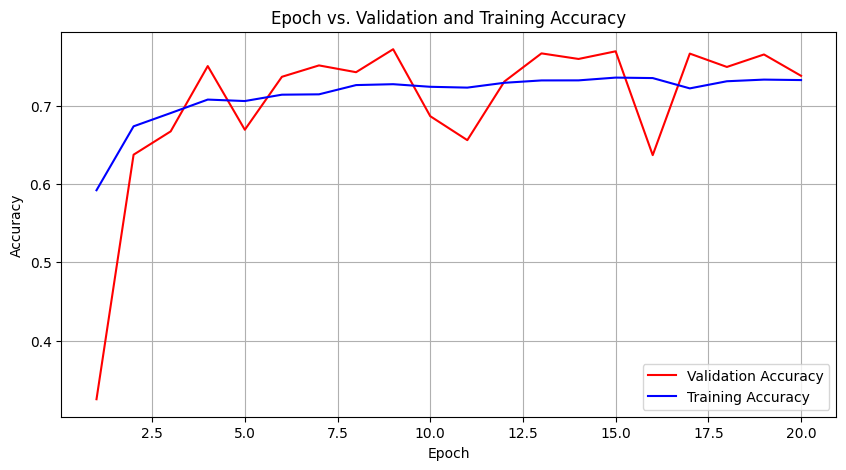

In [46]:
import matplotlib.pyplot as plt
print(hist)

val_acc = hist.history['val_accuracy']
train_acc = hist.history['accuracy']

epochs = range(1, len(hist.history['val_accuracy']) + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.plot(epochs, train_acc, 'b', label='Training Accuracy')
plt.title('Epoch vs. Validation and Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


In [47]:
testing_loss, testing_accuracy = model.evaluate(x_test_histograms, y_test)

print("Testing Loss:", testing_loss)
print("Testing Accuracy:", testing_accuracy)


160/160 [==============================] - 1s 7ms/step - loss: 0.7368 - accuracy: 0.7264
Testing Loss: 0.7368433475494385
Testing Accuracy: 0.726367175579071


In [48]:
import cv2
import numpy as np

scaled_channels = []
for channel in range(3):
    channel_data = bayes_extracted_noise[:, :, channel]
    max_value = np.max(channel_data)
    
    if max_value != 0:
        scaled_channel = (channel_data / max_value) * 255
    else:
        scaled_channel = channel_data

    scaled_channels.append(scaled_channel.astype(np.uint8))

scaled_bayes_extracted_noise = cv2.merge(scaled_channels)

[[[246   3 254]
  [254   1   4]
  [245   0 251]
  ...
  [  2   2 253]
  [253   4 255]
  [252   0 241]]

 [[254   0   5]
  [  6 254  10]
  [  4   5 252]
  ...
  [  2 254   6]
  [255 251   3]
  [  7   3   5]]

 [[248   6 254]
  [  4   0 255]
  [255 251  12]
  ...
  [255   5 250]
  [247 255   0]
  [  6   3   4]]

 ...

 [[250 252 253]
  [  0   4   4]
  [  1   3   7]
  ...
  [  2   1  13]
  [246   3   1]
  [  4   2 247]]

 [[  7   3   0]
  [  1   1 254]
  [  5 251   3]
  ...
  [  4 255 247]
  [254   0 245]
  [  1   0 253]]

 [[  4   0 255]
  [251   4 255]
  [255   0   1]
  ...
  [250   6   0]
  [253   1   1]
  [253   2   8]]]


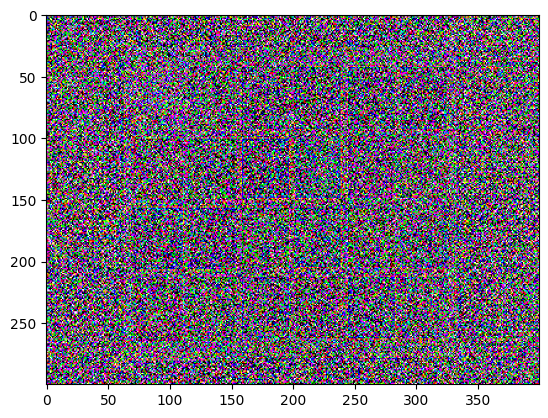

In [49]:
plt.imshow(scaled_bayes_extracted_noise)
print(scaled_bayes_extracted_noise)

In [50]:

import cv2

bayes_extracted_noise_hist = []


# Calculate and append histograms for each channel
hist_r = cv2.calcHist([scaled_bayes_extracted_noise[:, :, 0]], [0], None, [256], [0, 256])
hist_g = cv2.calcHist([scaled_bayes_extracted_noise[:, :, 1]], [0], None, [256], [0, 256])
hist_b = cv2.calcHist([scaled_bayes_extracted_noise[:, :, 2]], [0], None, [256], [0, 256])

bayes_extracted_noise_hist = [hist_r, hist_g, hist_b]


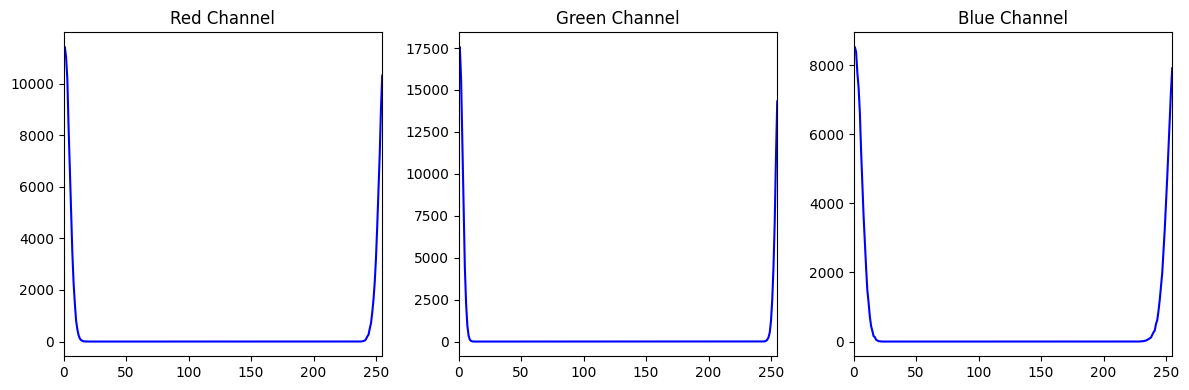

In [51]:
import matplotlib.pyplot as plt

# Create subplots for each channel's histogram
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# Set titles for each subplot
channel_titles = ['Red Channel', 'Green Channel', 'Blue Channel']

# Plot histograms for each channel
for i, hist in enumerate(bayes_extracted_noise_hist):
    axes[i].plot(hist, color='blue')
    axes[i].set_xlim([0, 255])  # Set the x-axis limits from 0 to 255
    axes[i].set_title(channel_titles[i])

plt.tight_layout()
plt.show()


In [52]:
print(model.input_shape)
print(bayes_extracted_noise_hist[0].shape)
reshaped_data = bayes_extracted_noise_hist[0].reshape(1, -1)

r_predict = model.predict(reshaped_data / np.sum(reshaped_data))

g_predict = model.predict(bayes_extracted_noise_hist[1].reshape(1, -1) / np.sum(bayes_extracted_noise_hist[1]))
b_predict = model.predict(bayes_extracted_noise_hist[2].reshape(1, -1) / np.sum(bayes_extracted_noise_hist[2]))

print(r_predict)

(None, 256)
(256, 1)
1/1 [==============================] - 0s 50ms/step
[[9.4318418e-03 2.0599541e-04 3.7903585e-05 2.3542909e-05 2.6892307e-05
  3.9093184e-06 7.9986967e-06 9.9026197e-01]]


In [53]:
print('r predict : ', np.argmax(r_predict))
print('g predict : ', np.argmax(g_predict))
print('b predict : ', np.argmax(b_predict))

r predict :  7
g predict :  7
b predict :  7


denoised image : 


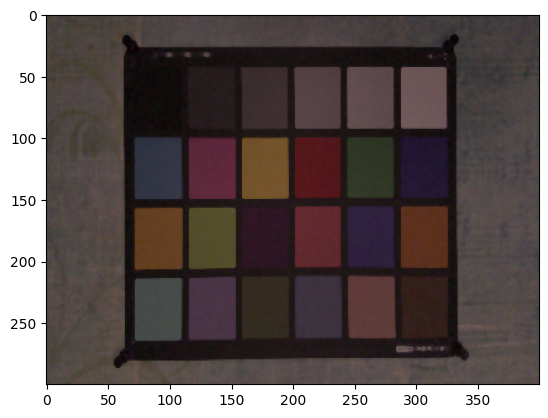

PSNR :  36.57394531611834


In [54]:
# As per the results, the type of noise is gamma
median_filtered_image = cv2.medianBlur(noisy_images[0], ksize=3)
print('denoised image : ')
plt.imshow(median_filtered_image)
plt.show()

print("PSNR : ", cv2.PSNR(ground_truth_images[0], median_filtered_image))

In [ ]:
# A helper function that takes in the noise type and image, and applies denoising filters to them

def denoise_image(noise_type, image):
    if noise_type == NoiseTypes.Gaussian.value:
        return cv2.fastNlMeansDenoisingColored(image, None, 10, 10, 7, 21)
    elif noise_type == NoiseTypes.SaltAndPepper.value:
        return cv2.medianBlur(image, 5)
    elif noise_type == NoiseTypes.Speckle.value:
        return cv2.medianBlur(image, 5)
    elif noise_type == NoiseTypes.Quantization.value:
        return cv2.fastNlMeansDenoisingColored(image, None, 10, 10, 7, 21)
    elif noise_type == NoiseTypes.Poisson.value:
        return cv2.fastNlMeansDenoisingColored(image, None, 10, 10, 7, 21)
    elif noise_type == NoiseTypes.Uniform.value:
        return cv2.fastNlMeansDenoisingColored(image, None, 10, 10, 7, 21)
    elif noise_type == NoiseTypes.White.avlue:
        return cv2.fastNlMeansDenoisingColored(image, None, 10, 10, 7, 21)
    elif noise_type == NoiseTypes.Gamma:
        return cv2.fastNlMeansDenoisingColored(image, None, 10, 10, 7, 21)
    else:
        return image  # No noise type specified, return the original image